# **5-Fold Validation for k-NN on cPCA and PCA**

## Install Constrastive Dependency

In [106]:
import time

start = time.time()

Most of the code was taken from the [contrastive repository](https://github.com/abidlabs/contrastive/tree/master) for reproducibillity goals. For the method, see the author's paper "Exploring Patterns Enriched in a Dataset with Contrastive Principal Component Analysis", *Nature Communications* (2018).

In [107]:
!git clone https://github.com/abidlabs/contrastive

fatal: destination path 'contrastive' already exists and is not an empty directory.


In [108]:
pip install contrastive

## Load Data

In [109]:
from sklearn.decomposition import PCA
from contrastive import CPCA

In [110]:
DATA_CORTEX_NUCLEAR_FILEPATH = "contrastive/experiments/datasets/Data_Cortex_Nuclear.csv"

In [111]:
import numpy as np
%matplotlib inline

data = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

<ipython-input-111-bbbec62b2beb>:6: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',


## Process Data

In [112]:
target_idx_A = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))[0]
target_idx_B = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))[0]

labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))

target = data[target_idx]

background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))
background = data[background_idx]

## Run Contrastive PCA

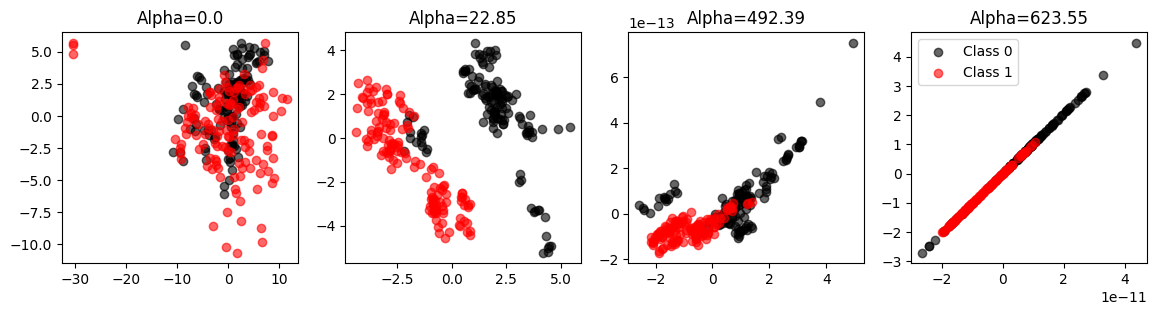

In [113]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from contrastive import CPCA

mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels)

In [114]:
projected_data_for_training = mdl.fit_transform(target, background, plot=False, active_labels=labels)
print(len(projected_data_for_training))

4


In [115]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=2
)

X_pca_projected_data = pca.fit_transform(target)

print(X_pca_projected_data.shape)


(270, 2)


In [116]:
from sklearn.utils import shuffle

## **Implement 5-fold cross validation**

Using PCA as a preprocessing tool

In [117]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

X_data, y_data = shuffle(X_pca_projected_data, np.array(labels))

for n_neighbors in [1, 3, 5]:

    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)
    clf_knn = KNeighborsClassifier(
        n_neighbors=n_neighbors
    )
    count = 0


    for train_index, test_index in kf.split(X_train):
        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = np.array(y_data)[train_index], np.array(y_data)[test_index]

        clf_knn.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
        test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.8910975609756097
Val acc std: 0.0119711133578615

n_neighbors = 3
Train acc mean: 0.9505022620964649
Train acc std: 0.012967429595526254
Val acc mean: 0.8764634146341465
Val acc std: 0.02607760805518471

n_neighbors = 5
Train acc mean: 0.926984126984127
Train acc std: 0.01427158321390994
Val acc mean: 0.8567073170731707
Val acc std: 0.03538267051809782



Results for cPCA alpha=0.0

In [118]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


X_data, y_data = shuffle(projected_data_for_training[0], np.array(labels))


for n_neighbors in [1, 3, 5]:

    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)

    count = 0

    for train_index, test_index in kf.split(X_train):

        clf_knn = KNeighborsClassifier(
            n_neighbors=n_neighbors
        )

        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = y_data[train_index], y_data[test_index]

        clf_knn.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
        test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.6782926829268292
Val acc std: 0.04070431384967242

n_neighbors = 3
Train acc mean: 0.8465608465608465
Train acc std: 0.019085141694418026
Val acc mean: 0.6530487804878048
Val acc std: 0.054677139007464924

n_neighbors = 5
Train acc mean: 0.7920941645579327
Train acc std: 0.022147840241776906
Val acc mean: 0.7073170731707317
Val acc std: 0.05358642604721815



Results for cPCA alpha=22.85

In [119]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


X_data, y_data = shuffle(projected_data_for_training[1], np.array(labels))


for n_neighbors in [1, 3, 5]:

    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)

    count = 0

    for train_index, test_index in kf.split(X_train):

        clf_knn = KNeighborsClassifier(
            n_neighbors=n_neighbors
        )

        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = y_data[train_index], y_data[test_index]

        clf_knn.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
        test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.965731707317073
Val acc std: 0.03647218264758937

n_neighbors = 3
Train acc mean: 0.9851545126907446
Train acc std: 0.0029991481308992212
Val acc mean: 0.9704878048780488
Val acc std: 0.024100720638118314

n_neighbors = 5
Train acc mean: 0.9802085729621961
Train acc std: 0.004588742536387971
Val acc mean: 0.9607317073170731
Val acc std: 0.03315996955972163



Results for cPCA alpha=492.39

In [120]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


X_data, y_data = shuffle(projected_data_for_training[2], np.array(labels))


for n_neighbors in [1, 3, 5]:

    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)

    count = 0

    for train_index, test_index in kf.split(X_train):

        clf_knn = KNeighborsClassifier(
            n_neighbors=n_neighbors
        )

        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = y_data[train_index], y_data[test_index]

        clf_knn.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
        test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.821829268292683
Val acc std: 0.04796327665201884

n_neighbors = 3
Train acc mean: 0.9047005597730235
Train acc std: 0.003093648377431507
Val acc mean: 0.826829268292683
Val acc std: 0.060879192062435396

n_neighbors = 5
Train acc mean: 0.8601717659688675
Train acc std: 0.009725133856908671
Val acc mean: 0.8419512195121952
Val acc std: 0.05232176339201244



Results for cPCA alpha=623.55

In [121]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


X_data, y_data = shuffle(projected_data_for_training[3], np.array(labels))


for n_neighbors in [1, 3, 5]:

    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)

    count = 0

    for train_index, test_index in kf.split(X_train):

        clf_knn = KNeighborsClassifier(
            n_neighbors=n_neighbors
        )

        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = y_data[train_index], y_data[test_index]

        clf_knn.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
        test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.7717073170731708
Val acc std: 0.0684379987058722

n_neighbors = 3
Train acc mean: 0.8700099685606932
Train acc std: 0.01778194051529215
Val acc mean: 0.8112195121951219
Val acc std: 0.09056682500667998

n_neighbors = 5
Train acc mean: 0.8588758530787516
Train acc std: 0.016608355629858934
Val acc mean: 0.8209756097560975
Val acc std: 0.08191055901874093



In [122]:
end = time.time()
print(f"Elapsed time: {round(end-start, 2)} seconds")

Elapsed time: 14.88 seconds
